# 1880 Disambiguation V.2

Improves on confidence score generating process in `disambiguation_analysis.ipynb`  
Summary of actions:
- add column with number of potential CD matches for each census record ('census conflicts')
- confidence score to include age and number of **census conflicts**
    - diff between CD and census conflicts: if one CD is matched to 2 census records, CD conflict is 2. But, for those two census records, this CD record might be the only record matched to them, hence they might both have census conflict 1.  
    - we are looking at census records to be anchors for spatial disambiguation, where confidence = 1. Hence, confidence score should calculate census conflicts instead of CD conflicts.  
    - no. of conflicts for CD used in disambiguation process instead.

Next steps - Spatial disambiguation:
- first find anchor points (confidence = 1)
- split into graphs, anchored by 2 anchor points
- shortest path for each

In [53]:
import pandas as pd
import networkx as nx
import numpy as np

In [2]:
pd.set_option('display.min_rows', 1000)

In [3]:
match = pd.read_csv("data/match_results_confidence_score.csv")

In [4]:
latlng = pd.read_csv("data/cd_1880.csv")
latlng = latlng[['OBJECTID', 'LONG', 'LAT']]

In [5]:
match = match.merge(latlng, how='left', left_on='OBJECTID', right_on='OBJECTID', validate='many_to_one')

In [6]:
# sort by original census order
match = match.sort_values(by = ['OBJECTID.x'])

## RE-Constructing a confidence score
#### Using the following weightage (abitrarily decided) in the confidence score
1. **50%** - Jaro-Winkler distance
2. **20%** - No. of CD matches (conflicts)
3. **20%** - No. of census matches
4. **5%** - Absence of occupation in the census (*)
5. **5%** - Whether age is smaller than 12

In [7]:
# recalculate the scores to include age and census conflicts
match['age_score'] = match['CENSUS_AGE'].apply(lambda x: 0 if x <= 12 else 1)
match["census_count"] = match.groupby("OBJECTID.x")["OBJECTID"].transform('count')
match['confidence_score'] = .5*match.jaro_winkler_aggr_score + .2*(1/match.num_matches) + \
                            .2*(1/match.census_count) + .05*match.census_occupation_listed + \
                            .05*match.age_score
match['confidence_score'] = match['confidence_score'].round(decimals = 2)

## Extracting Anchor Points
Confidence score = 1 matches will now serve as anchor points for disambiguation

How many anchor points are there and what do they look like?

In [8]:
len(match[match.confidence_score == 1])

48716

In [9]:
match[match.confidence_score == 1].head()

,OBJECTID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,OBJECTID.x,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,...,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count
12387,21703,Henry,Tegeler,"1 STATE ST, New York, NY",shoes,1,469,HENRY,TEGELER,"1 STATE ST, NYC-Manhattan, NY",...,1,26,649,1,1.0,1.0,-74.012948,40.702488,1,1
47353,79694,John,Mooney,"1 STATE ST, New York, NY",driver,1,474,JOHN,MOONEY,"1 STATE ST, NYC-Manhattan, NY",...,1,26,649,1,1.0,1.0,-74.012948,40.702488,1,1
67592,111786,Charles,Kramer,"6 STATE ST, New York, NY",eatingh,1,495,CHARLES,KRAMER,"6 STATE ST, NYC-Manhattan, NY",...,1,26,649,1,1.0,1.0,-74.013676,40.702483,1,1
54453,90566,Patrick,Madden,"8 STATE ST, New York, NY",coachman,1,522,PATRICK,MADDEN,"8 STATE ST, NYC-Manhattan, NY",...,1,26,649,1,1.0,1.0,-74.013890,40.702564,1,1
104939,170991,Ellen,Dunn,"8 STATE ST, New York, NY",wid Thomas high,1,530,ELLEN,DUNN,"8 STATE ST, NYC-Manhattan, NY",...,1,26,649,1,1.0,1.0,-74.013890,40.702564,1,1


In [10]:
# rename objectIDs to prevent errors
match = match.rename(columns={'OBJECTID': 'CD_ID', 'OBJECTID.x': 'CENSUS_ID'})

In [11]:
match.columns

Index(['CD_ID', 'CD_FIRST_NAME', 'CD_LAST_NAME', 'MATCH_ADDR', 'CD_OCCUPATION',
       'num_matches', 'CENSUS_ID', 'CENSUS_NAMEFRSCLEAN', 'CENSUS_NAMELASTB',
       'CENSUS_MATCH_ADDR', 'CENSUS_AGE', 'CENSUS_OCCLABELB', 'WARD_NUM',
       'CENSUS_ENUMDIST', 'CENSUS_SEGMENT_ID', 'CD_BLOCK_NUM',
       'census_occupation_listed', 'jaro_winkler_aggr_score',
       'confidence_score', 'LONG', 'LAT', 'age_score', 'census_count'],
      dtype='object')

They look good!! First step of preprocessing - since these are anchor points, they cannot be potential matches in any other records. Hence we will extract them and make sure they are no longer potential matches for other records.

In [12]:
# some preprocessing - since these are anchor points, they cannot be potential matches in any other records
anchor_CDs = match[match.confidence_score == 1].CD_ID.tolist()
anchor_census = match[match.confidence_score == 1].CENSUS_ID.tolist()


In [13]:
# remove the records that have anchor_CDs/anchor_census as potential matches, but DO NOT remove the anchors themselves
non_anchor_matches = match[~ match.CD_ID.isin(anchor_CDs) 
                           & ~ match.CENSUS_ID.isin(anchor_census) 
                           & match.confidence_score != 1]

# Prototyping a graph
- have to take into account records above and below anchors
- has to be iterative for the removal of duplicates.

In [14]:
# Pick a small subset of the data, anchored by 2 points
sub = match[(match.CENSUS_ID >= 326668) & (match.CENSUS_ID <= 326774)]
sub

,CD_ID,CD_FIRST_NAME,CD_LAST_NAME,MATCH_ADDR,CD_OCCUPATION,num_matches,CENSUS_ID,CENSUS_NAMEFRSCLEAN,CENSUS_NAMELASTB,CENSUS_MATCH_ADDR,...,CENSUS_ENUMDIST,CENSUS_SEGMENT_ID,CD_BLOCK_NUM,census_occupation_listed,jaro_winkler_aggr_score,confidence_score,LONG,LAT,age_score,census_count
20468,34093,Raphael,Silverstein,"29 ESSEX ST, New York, NY",tailor,1,326668,RAPHAEL,SILVERSTEIN,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,1,1.000,1.00,-73.989769,40.715749,1,1
52853,88036,Henry,Marks,"43 ESSEX ST, New York, NY",tailor,2,326672,HENRY,MARKS,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,1,1.000,0.85,-73.989470,40.716326,0,1
63475,104822,Harris,Levy,"44 ALLEN ST, New York, NY",pedlar,3,326688,HARRIS,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,1267,1,0.910,0.72,-73.991798,40.716435,1,2
63472,104820,Harris,Levy,"45 HESTER ST, New York, NY",grocer,3,326688,HARRIS,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,1,0.910,0.72,-73.989941,40.715697,1,2
63393,105156,Simon,Levi,"36 LUDLOW ST, New York, NY",tailor,4,326690,SIMON,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,0,1.000,0.59,-73.990371,40.715932,0,5
63397,105157,Simon,Levi,"59 HESTER ST, New York, NY",pedlar,4,326690,SIMON,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,1268,0,1.000,0.59,-73.990716,40.715931,0,5
63389,104712,Simon,Levy,"58 ORCHARD ST, New York, NY",tailor,4,326690,SIMON,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,1268,0,0.910,0.55,-73.990787,40.716811,0,5
63385,104711,Simon,Levy,"41 LUDLOW ST, New York, NY",tailor,4,326690,SIMON,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,1268,0,0.910,0.55,-73.990485,40.716161,0,5
63381,104703,Simon,Levy,"27 ESSEX ST, New York, NY",hairs,4,326690,SIMON,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,0,0.910,0.55,-73.989811,40.715666,0,5
63296,104620,Morris,Levy,"29 ESSEX ST, New York, NY",tailor,5,326692,MORRIS,LEVI,"29 ESSEX ST, NYC-Manhattan, NY",...,198,917,190,1,0.910,0.70,-73.989769,40.715749,1,2


Quick note: this subset was chosen as it is bounded by two anchor points (first and last record, where confidence = 1) and contains examples of census records with multiple matches. 

In [94]:
# prepare dataframe in format to create graph
# this cell creates unique ids for the nodes
sub_graph = sub[['CD_ID', 'CENSUS_ID', 'LONG', 'LAT', 'confidence_score', 'MATCH_ADDR']]
sub_graph['anchor'] = sub_graph['confidence_score'].apply(lambda x: 1 if x == 1 else 0)
sub_graph['node_ID'] = sub_graph.groupby('CENSUS_ID').cumcount()

letter_id = sub_graph['CENSUS_ID'].unique().tolist()
letters = [chr(x+65) for x in range(0, len(letter_id))]
letter_id = pd.DataFrame({'CENSUS_ID': letter_id, 'letter': letters})

sub_graph = sub_graph.merge(letter_id, how='left', on='CENSUS_ID', validate='many_to_one')

sub_graph['node_ID'] = sub_graph.apply(lambda row: row.letter + str(row.node_ID), axis=1)

In [95]:
sub_graph

,CD_ID,CENSUS_ID,LONG,LAT,confidence_score,MATCH_ADDR,anchor,node_ID,letter
0,34093,326668,-73.989769,40.715749,1.00,"29 ESSEX ST, New York, NY",1,A0,A
1,88036,326672,-73.989470,40.716326,0.85,"43 ESSEX ST, New York, NY",0,B0,B
2,104822,326688,-73.991798,40.716435,0.72,"44 ALLEN ST, New York, NY",0,C0,C
3,104820,326688,-73.989941,40.715697,0.72,"45 HESTER ST, New York, NY",0,C1,C
4,105156,326690,-73.990371,40.715932,0.59,"36 LUDLOW ST, New York, NY",0,D0,D
5,105157,326690,-73.990716,40.715931,0.59,"59 HESTER ST, New York, NY",0,D1,D
6,104712,326690,-73.990787,40.716811,0.55,"58 ORCHARD ST, New York, NY",0,D2,D
7,104711,326690,-73.990485,40.716161,0.55,"41 LUDLOW ST, New York, NY",0,D3,D
8,104703,326690,-73.989811,40.715666,0.55,"27 ESSEX ST, New York, NY",0,D4,D
9,104620,326692,-73.989769,40.715749,0.70,"29 ESSEX ST, New York, NY",0,E0,E


In [56]:
# produce table where each row is an edge on the graph
g = sub_graph
g['key'] = 0
g = g.merge(g, on='key')
g['key'] = g.apply(lambda row: 1 if ord(row.letter_x) - ord(row.letter_y) == -1 else 0, axis = 1)
g = g[g.key == 1]

## weight is currently ONLY manhattan distance - need to ultimately add confidence score
g['weight'] = g.apply(lambda row: ((row.LONG_y - row.LONG_x)**2 + (row.LAT_y - row.LONG_x)**2)**(1/2), axis=1)

In [60]:
g_edges = [(row.node_ID_x, row.node_ID_y, row.weight) for index, row in g.iterrows()]

INSERT A CONCEPTUAL DIAGRAM to show what the graph looks like + what least cost is doing

In [76]:
# create graph and use algorithm to find shortest path
graph = nx.Graph()
graph.add_weighted_edges_from(g_edges)
path = nx.dijkstra_path(graph, 'A0', 'J0')

In [119]:
# these nodes form the shortest-path (i.e. closest to each other)
path

['A0', 'B0', 'C1', 'D4', 'E0', 'F0', 'G0', 'H0', 'I0', 'J0']

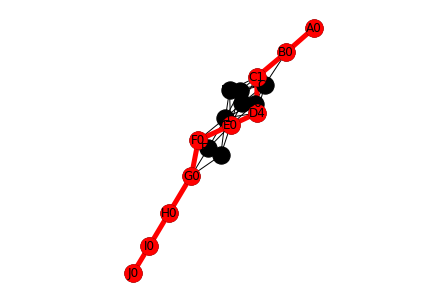

In [84]:
## SIMPLE VISUALIZATION: NEEDS IMPROVEMENT.
import matplotlib.pyplot as plt

pos = nx.spring_layout(graph)
nx.draw(graph,pos,node_color='k',with_labels=True)
# draw path in red
path_edges = list(zip(path,path[1:]))
nx.draw_networkx_nodes(graph,pos,nodelist=path,node_color='r')
nx.draw_networkx_edges(graph,pos,edgelist=path_edges,edge_color='r',width=5)
plt.axis('equal')
plt.show()


In [116]:
import folium

map_viz = folium.Map(
    location = (sub_graph.LAT.tolist()[0], sub_graph.LONG.tolist()[0]),
    zoom_start = 30,
)

pal = {'A': 'red', 'B': 'orange', 'C': 'yellow', 'D': 'green', 'E': 'blue', 'F': 'purple', 'G': 'white', 'H': 'black', 'I': 'pink', 'J': 'brown'}

for index, row in sub_graph.iterrows():
    folium.CircleMarker(
        location = (row['LAT'], row['LONG']),
        opacity = 0,
        fill = True,
        fill_opacity = 0.7,
        color = pal[row['letter']],
        size = 0.1,
        tooltip = ('<b>Node</b>: ' + str(row['node_ID']) + '<br>'
                   '<b>Address:</b> ' + row['MATCH_ADDR'] + '<br>')
    ).add_to(map_viz)

points = [(row.LAT, row.LONG) for index, row in sub_graph[sub_graph.node_ID.isin(path)].iterrows()]

folium.PolyLine(points).add_to(map_viz)

In [117]:
# HOW TO READ THIS MAP:
# same color = these points are different location options for the same census record
# lines connect the shortest path
# hover over to see details

map_viz

### What is happening?
Some nodes 'disappeared' because they are overlapping - this may or may not be a problem. 
- It could be a problem because the nodes may not ACTUALLY be unique, ie the same CD record is a potential for many census records and was selected multiple time in the least cost algorithm, although we know that a CD record only maps to one census record. 
- Not be a problem - different CD records may share the same address, for example. Fix to this is described in next steps.

BUT this does show the basic idea works - there is some evident clustering at the corner of Essex Street. The 'far away' points only were chosen because those were the only choice.

### Some next steps:
- Documentation: some accompanying conceptual diagrams
- Integrate confidence score into weighting process
- Implement the correct path finding algorithm: should look at all path lengths, filter out those that contain non-unique (in terms of CD_ID) nodes, then select shortest path
- How to deal with census records that may truly not have a CD match? Set threshold of weight? (How to identify in the first place?)

